# Data Mining / Prospecção de Dados

## Sara C. Madeira, 2019/20

# Project 3 - Classification/Regression

## Logistics

**In a "normal" scenario students should work in teams of 2 people. Due to the social distance imposed by current public health situation, students were allowed to work in groups of 1 and 3. In this context, the amount of work was adapted according to the number of students in groups as described below.**

* Tasks **1 to 4** should be done by **all** groups **BUT**
    * In Tasks **2 and 3** the number of classifiers/regressors to use is **`X` = 2, 3 and 4**  for groups of 1, 2 and 3 students, respectively.
    * In Task **4**, groups of 1, 2 and 3 students should try 1, 2 and 3 ensemble approaches, respectively.

The quality of the project will then dictate its grade.

**The project's solution should be uploaded in Moodle before the end of June, 9th 2020 (23:59).** 

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. Note that you can use `PD_201920_Project3.ipynb`as template.**

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 

**Decisions should be justified and results should be critically discussed.**

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[Scikit-learn](http://scikit-learn.org/stable/). You are also allowed to use [Orange3](https://orange.biolab.si).**

The dataset to be analysed is **`ModifiedHousePrices.csv`**, a modified version of the train dataset used in Kaggle's competition ["House Prices: Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). 

If you ask a home buyer to describe their dream house, they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With more than 70 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

**This project challenges you twice** by asking you to tackle a
1. **Regression Task**: predict the price, and a
2. **Classification Task**: predict a price category.

The variables are described [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The targets are:
1. `SalePrice` - the property's sale price in dollars. This is the target variable that you're trying to predict in the regression task (same as in the Kaggle challenge).
2. `Price3Classes` - the price category, where price can be below 200000 ("<200000"), between 200000 and 400000 ("[200000,400000]"), or above 200000 (">200000"). This is the target variable that you're trying to predict in the classification task. 

# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#import smogn
import os
from imblearn.combine import SMOTETomek
from scipy import stats
from scipy.stats import norm

## 1. Load and Preprocess Dataset

Here you might consider useful to think about:
1. Missing Value Imputation
2. Feature Selection
3. Class Imbalance

In [2]:
df_data = pd.read_csv('data/ModifiedHousePrices.csv')
df_data.shape

(1460, 82)

In [3]:
df_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Price3Classes
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,"[200000,400000]"
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,<200000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,"[200000,400000]"
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,<200000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,"[200000,400000]"


## 1.1. Exploratory Data Analysis

### 1.1.1 Continuous Variable - SalePrice

Text(0.5, 0, 'Price')

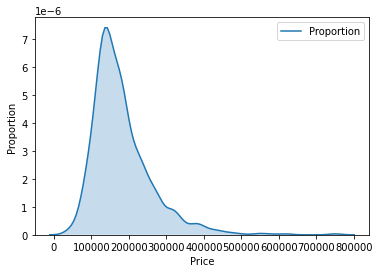

In [4]:
sns.kdeplot(df_data['SalePrice'], shade=True)
plt.legend(['Proportion'])
plt.ylabel('Proportion')
plt.xlabel('Price')

### 1.1.2. Categorical Variable - Price3Classes

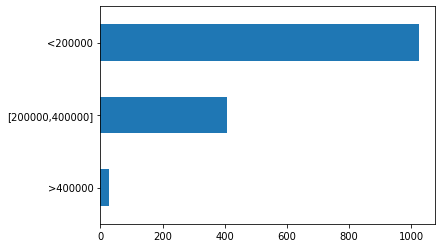

In [5]:
df_data.Price3Classes.value_counts().sort_values().plot(kind = 'barh')

We can see that we have an unbalanced dataset for the classification task.

### 1.1.3. Feature Exploration

Bellow we will define two vectors that saves the categorical and continuous variables that we identified by analysing the dataset. 

In [6]:
cat_var = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'MoSold',
    'SaleType',
    'SaleCondition'
]

num_var = [
    'LotFrontage',
    'LotArea',
    'OverallQual',
    'OverallCond',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',    
    'GarageCars',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'YrSold',
]

Now lets create a dataframe with information about the columns of the dataset. The dataframe have the following columns:

+ column: indicates the columns name;
+ type: indicates if the column is categorical or continuous
* data_type: the data type of the column;
* max: if the column is a continuous variable, the maximum of that column;
* min: if the column is a continuous variable, the minimum of that column;
* mean: if the column is a continuous variable, the mean of that column;
* std: if the column is a continuous variable, the standard deviation of that column;
* nulls_count: the number of records with that column being null;
* nulls_percentage: the percentage of nulls of that column;
* unique_count: the number of unique rows;
* zero_count: the number of records with zero.

In [7]:
all_columns = cat_var + num_var
template_df = list()

df_var_columns = [
    'column',
    'type',
    'data_type',
    'max',
    'min',
    'mean',
    'std',
    'nulls_count',
    'nulls_percentage',
    'unique_count',
    'zero_count',
]

for s in all_columns:
    template_df.append([s]+['']*(len(df_var_columns)-1))

df_variables_info = pd.DataFrame(template_df, columns=df_var_columns).set_index('column')

In [8]:
empty_df = []
total_rows = len(df_data)

for s in df_data.loc[:,'MSSubClass':'SaleCondition'].columns:

    nullable_values = len(df_data[s][df_data[s].isnull()])
    df_variables_info.loc[s, 'nulls_count'] = nullable_values
    df_variables_info.loc[s, 'nulls_percentage'] = (nullable_values/total_rows) * 100
    df_variables_info.loc[s, 'data_type'] = df_data[s].dtype
    df_variables_info.loc[s, 'unique_count'] = len(df_data[s].unique())
    #add column zero_count for features with dtype int64 or float64
    if (df_data[s].dtype == np.int64) | (df_data[s].dtype == np.float64) : 
        df_variables_info.loc[s, 'zero_count'] = len(df_data[df_data[s] == 0])
    if s in cat_var: df_variables_info.loc[s, 'type'] = 'categorical'
    elif s in num_var: 
        df_variables_info.loc[s, 'type'] = 'numerical'
        df_describe = df_data[s].describe().to_frame()
        df_variables_info.loc[s, 'mean'] = df_describe.loc['mean',s]
        df_variables_info.loc[s, 'std'] = df_describe.loc['std',s]
        df_variables_info.loc[s, 'min'] = df_describe.loc['min',s]
        df_variables_info.loc[s, 'max'] = df_describe.loc['max',s]
df_variables_info = df_variables_info.reset_index()

Now lets do some analysis based on the dataframe defined above.

Lets explore the type of features that the dataset has.

Text(0.5, 1.0, 'Types of columns')

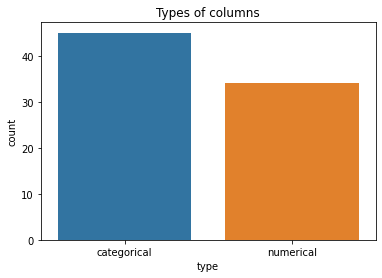

In [9]:
df_graph = df_variables_info.groupby('type').size().to_frame('count').reset_index()
sns.barplot(x='type',y='count', data = df_graph)
plt.title('Types of columns')

We can see that we have more categorical columns than numerical.

Now lets plot the percentage of nulls for each column

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text major ticklabel objects>)

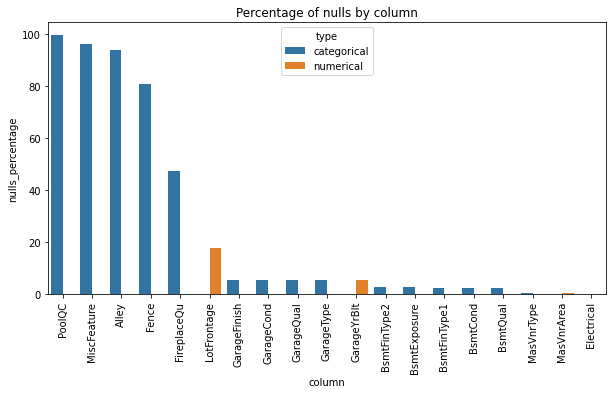

In [10]:
#get just columns with null values
df_graph = df_variables_info[df_variables_info['nulls_percentage']> 0].sort_values('nulls_percentage',ascending = False)
#plot them
plt.figure(figsize=(10,5))
sns.barplot(x='column', y = 'nulls_percentage', hue='type', data = df_graph)
plt.title('Percentage of nulls by column')
plt.xticks(rotation=90)

We can see that we have 5 categorical columns with with more than 50% of nulls, and just 3 continuous features with missing values.

Now lets analyse the amount of zeros by continuous column

/home/gustavosf/Documents/GitHub/DataMining-Project-3/dm-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

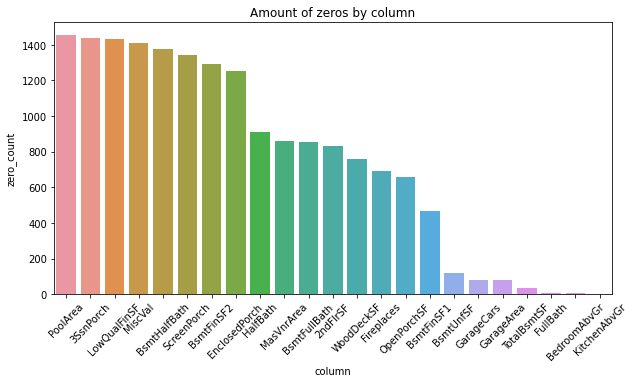

In [11]:
df_graph = df_variables_info[(df_variables_info['type'] == 'numerical') & (~df_variables_info['zero_count'].isnull())]
df_graph['zero_count'] = df_graph['zero_count'].astype(int)
df_graph = df_graph[df_graph['zero_count']>0].sort_values('zero_count',ascending = False)
plt.figure(figsize=(10,5))
sns.barplot(x='column',y='zero_count', data = df_graph)
plt.title('Amount of zeros by column')
plt.xticks(rotation=45)

In [12]:
df_data['PoolArea'].describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

We have some features with a huge amount of zeros, but we consider that those features could be important in order to describe our target variables (the price of the house). For example, the feature PoolArea have most of his values being zero, but it is useful to describe the price of the houses, because a house with a pool is generally more expensive

## 1.2. Missing Values inputation

### Continuous features

Numerical valued columns with missing values are:
+ Linear feet of street connected to property (LotFrontage), with almost 20% of nulls.
+ Masonry veneer area in square feet (MasVnrArea), with around 0.5% of nulls, just 8 records.
+ Year the garage was built (GarageYrBlt), with around 5.5% of nulls.

Bellow we define a function that will be used in order to analyse the feature distribution of that features.

In [13]:
def feature_dist(df, column_name):
    """"""
    plt.figure(figsize=(15,4))
    sns.distplot(df[column_name] , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[column_name])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(column_name))
    plt.show()

Lets analyse the distribution of 'LotFrontage' feature.

Records with missing values: 259

 mu = 70.05 and sigma = 24.27



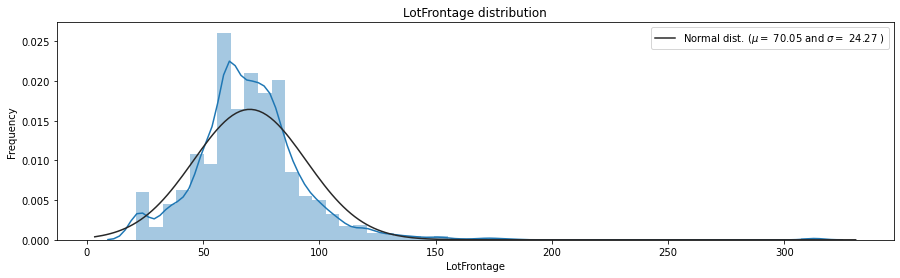

In [14]:
print('Records with missing values: {}'.format(len(df_data[df_data['LotFrontage'].isnull()])))
df_graph = df_data[df_data['LotFrontage']>=0]
feature_dist(df_graph, 'LotFrontage')

By analysing the graph above we can see that the feature distribution is similar to a gaussian distribution, with a mean of 70.05 and a standard deviation of 24.27. Because of that, we decided to impute the mean to the missing values.

In [15]:
df_lotfrontagenulls = df_data[df_data['LotFrontage'].isnull()]
m = df_data['LotFrontage'].mean()
for i, r in df_lotfrontagenulls.iterrows():
    df_data.loc[i,'LotFrontage'] = m

Now lets analyse the distribution of 'MasVnrArea' feature.

Records with missing values: 8

 mu = 103.69 and sigma = 181.00



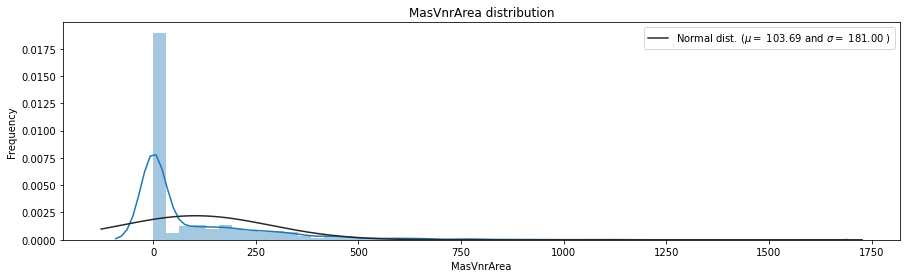

In [16]:
print('Records with missing values: {}'.format(len(df_data[df_data['MasVnrArea'].isnull()])))
df_graph = df_data[df_data['MasVnrArea']>=0]
feature_dist(df_graph, 'MasVnrArea')

We can see that this features does not have a gaussian distribution, so impute the mean could not be a good solution for that feature. By analysing the dataset description in [1], we can see that 'MasVnrArea' is related to 'MasVnrType'. Lets analyse the information that we have about those features.

In [17]:
df_variables_info[(df_variables_info['column'] == 'MasVnrType') | (df_variables_info['column'] == 'MasVnrArea')]

,column,type,data_type,max,min,mean,std,nulls_count,nulls_percentage,unique_count,zero_count
18,MasVnrType,categorical,object,,,,,8,0.547945,5,
51,MasVnrArea,numerical,float64,1600,0,103.685,181.066,8,0.547945,328,861


In [18]:
df_data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

We can see that 'MasVnrType' is categorical and can assume 4 possible values. By analysing the dataframe 'df_variables_info' that we created, with information about the features, we can observe that both the two features have 8 nulls. Lets check if those 8 records are the same.

In [19]:
df_data[df_data['MasVnrType'].isnull()].index.values, df_data[df_data['MasVnrArea'].isnull()].index.values

(array([ 234,  529,  650,  936,  973,  977, 1243, 1278]),
 array([ 234,  529,  650,  936,  973,  977, 1243, 1278]))

We can see that when 'MasVnrType' is null, 'MasVnrArea' is null as well. By analysing the 4 possible values that the 'MasVnrType' could assume, we decided to impute 'None' to 'MasVnrType' and 0 to 'MasVnrArea'.

In [20]:
for i in df_data[df_data['MasVnrType'].isnull()].index.values:
    df_data.loc[i,'MasVnrType'] = 'None'
    df_data.loc[i,'MasVnrArea'] = 0

Now lets explore the 'GarageYrBlt' feature distribution

Records with missing values: 81

 mu = 1978.51 and sigma = 24.68



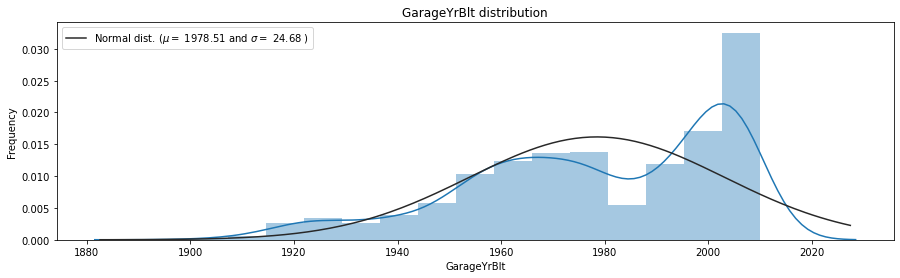

In [21]:
print('Records with missing values: {}'.format(len(df_data[df_data['GarageYrBlt'].isnull()])))
df_graph = df_data[df_data['GarageYrBlt']>=0]
feature_dist(df_graph, 'GarageYrBlt')

The feature has a mean around 1980 and a standard deviation of 25. We could assign the missing values with the mean of the feature, but we decided to assign it with the same value as the 'YearBuilt', which represents the year that the house was built. This prevent us from having cases were GarageYrBlt < YearBuilt

In [22]:
df_garageyearnulls = df_data[df_data['GarageYrBlt'].isnull()]
for i, r in df_garageyearnulls.iterrows():
    df_data.loc[i,'GarageYrBlt'] = r.YearBuilt

### Categorical Features

Categorical columns with missing values are a lot more, they include:
+ Type of alley access (Alley)
+ Masonry veneer type (MasVnrType)
+ Height of the basement (BsmtQual)
+ General condition of the Basement (BsmtCond)
+ Walkout of garden level basement walls (BsmtExposure)
+ Quality of basement finished area (BsmtFinType1)
+ Quality of second finished area (BsmtFinType2)
+ Electrical System (Electrical)
+ Fireplace quality (FireplaceQu)
+ Garage location (GarageType)
+ Interior finish of the garage (GarageFinish)
+ Garage quality (GarageQual)
+ Garage condition (GarageCond)
+ Pool quality (PoolQC)
+ Fence quality (Fence)
+ Miscellaneous feature not covered in other categories (MiscFeature)

Bellow we have a graph that identify the percentage of nulls in the categorical variables. As we can see by looking to the graph, the first 5 columns have most of his values being null. We decided to remove that first 5 columns from the dataset.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

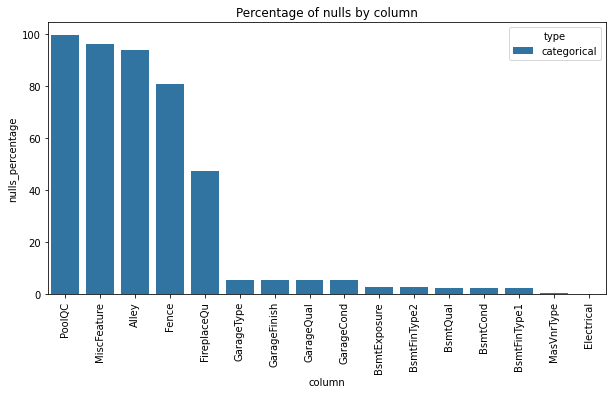

In [23]:
#get just columns with null values
df_graph = df_variables_info[(df_variables_info['nulls_percentage']> 0)&(df_variables_info['type']=='categorical')].sort_values('nulls_percentage',ascending = False)
#plot them
plt.figure(figsize=(10,5))
sns.barplot(x='column', y = 'nulls_percentage', hue='type', data = df_graph)
plt.title('Percentage of nulls by column')
plt.xticks(rotation=90)

In [24]:
cols_to_remove = [
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence',
    'FireplaceQu'
]
for c in cols_to_remove: df_data.drop(c, axis=1, inplace=True)

For the other categorical columns we will input 'unknown' since it is impossible to know if the missing data was forgotten to be added or if it was just because it was not applicable. Beside that, these remaining categorical features have few values 

In [25]:
cat_var2 = np.setdiff1d(cat_var,cols_to_remove)
# yields the elements in `list_2` that are NOT in `list_1`
df_data[cat_var2] = df_data[cat_var2].fillna('unknown')

## Features Encoding

In this section we will encode the categorical features. We decided to use leave one out encoding strategy for the features, and the label encoder for the target (classification task)

Bellow we define a function that get the data for the machine learning task.

In [26]:
def get_data(df, features=None, regression=True):
    """Creates data.
    
    Parameters:
        df (DataFrame): table with rows and columns
        features (Index, Series, list): vector of column names to include in data
        binary (bool): choose which target values to use
    
    Returns:
        ndarray: matrix of features values
        ndarray: vector of target values
        ndarray, Index, list: vector of feature names
        string: target name
    
    """
    if features is None: 
        features = df.columns.tolist()
    
    # guarantee that target features are not included
        features.remove('Id')
        features.remove('Price3Classes')
        features.remove('SalePrice')
    
    X = df[features]
    
    if regression == True:
        y = df[['SalePrice']]
        target = 'SalePrice'
    else:
        y = df[['Price3Classes']]
        target = 'Price3Classes'
    
    return X, y, features, target

In [27]:
df_X, df_y_reg, features, target_r = get_data(df_data, regression=True)
df_X, df_y_cat, features, target_c = get_data(df_data, regression=False)
df_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


Encode the target variable by using Label Encoder.

In [28]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_y_cat_enc = le.fit(df_y_cat)
df_y_cat_enc = le.transform(df_y_cat)
df_y_cat_enc

/home/gustavosf/Documents/GitHub/DataMining-Project-3/dm-ml/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([2, 0, 2, ..., 2, 0, 0])

Encode the categorical features by using Leave One Out Encoder.

In [29]:
import category_encoders as ce

encoder = ce.LeaveOneOutEncoder(cols = cat_var2)
encoder.fit(df_X, df_y_cat_enc)
df_X_encoded = encoder.transform(df_X)
df_X_encoded.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.163880,0.654214,65.0,8450,0.577717,0.422703,0.559878,0.577108,0.543726,0.563676,...,61,0,0,0,0,0,0.653846,2008,0.519337,0.534224
1,0.615672,0.654214,80.0,9600,0.577717,0.422703,0.559878,0.577108,0.468085,0.563676,...,0,0,0,0,0,0,0.539216,2007,0.519337,0.534224
2,1.163880,0.654214,68.0,11250,0.577717,0.832645,0.559878,0.577108,0.543726,0.563676,...,42,0,0,0,0,0,0.793651,2008,0.519337,0.534224
3,0.466667,0.654214,60.0,9550,0.577717,0.832645,0.559878,0.577108,0.596958,0.563676,...,35,272,0,0,0,0,0.653846,2006,0.519337,0.267327
4,1.163880,0.654214,84.0,14260,0.577717,0.832645,0.559878,0.577108,0.468085,0.563676,...,84,0,0,0,0,0,0.847458,2008,0.519337,0.534224


## Balancing data

As we have seen in the previous section we have an unbalanced dataset for the classification task. We will use SMOTE oversampling strategy in order to balance our dataset.

dataset size: 1460


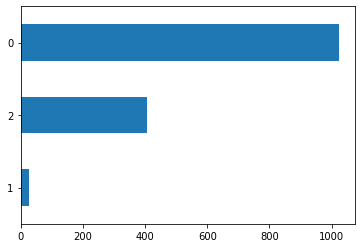

In [30]:
print('dataset size: {}'.format(len(df_X_encoded)))
pd.DataFrame(df_y_cat_enc, columns = [target_c])[target_c].value_counts().sort_values().plot(kind = 'barh')

In [31]:
smt = SMOTETomek(random_state=1)
df_X_encoded_balanced, y_cat_enc_balanced = smt.fit_resample(df_X_encoded, df_y_cat_enc)

dataset size: 3045


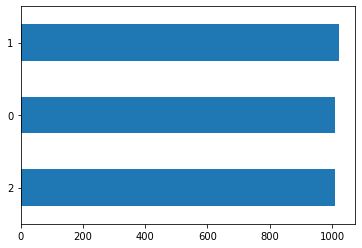

In [32]:
print('dataset size: {}'.format(len(df_X_encoded_balanced)))
pd.DataFrame(y_cat_enc_balanced, columns = [target_c])[target_c].value_counts().sort_values().plot(kind = 'barh')

We can see that after applying the SMOTE oversampling algorithm, our dataset increases from 1460 records to 3045 records.

## 1.3. Feature Selection

As the number of features increases, the model becomes more complex. The more the number of features, the more the chances of overfitting. A machine learning model that is trained on a large number of features, gets increasingly dependent on the data it was trained on and in turn becomes overfitted, resulting in poor performance on real data, beating its purpose.

We therefore do a dimensionality reduction. In order to do that, we will use a Random Forest in order to obtain the feature_importances.

### 1.3.2. Feature Selection

#### For Regression

In [33]:
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(df_X_encoded, df_y_reg)

/home/gustavosf/Documents/GitHub/DataMining-Project-3/dm-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(random_state=1)

Text(0, 0.5, 'Importance')

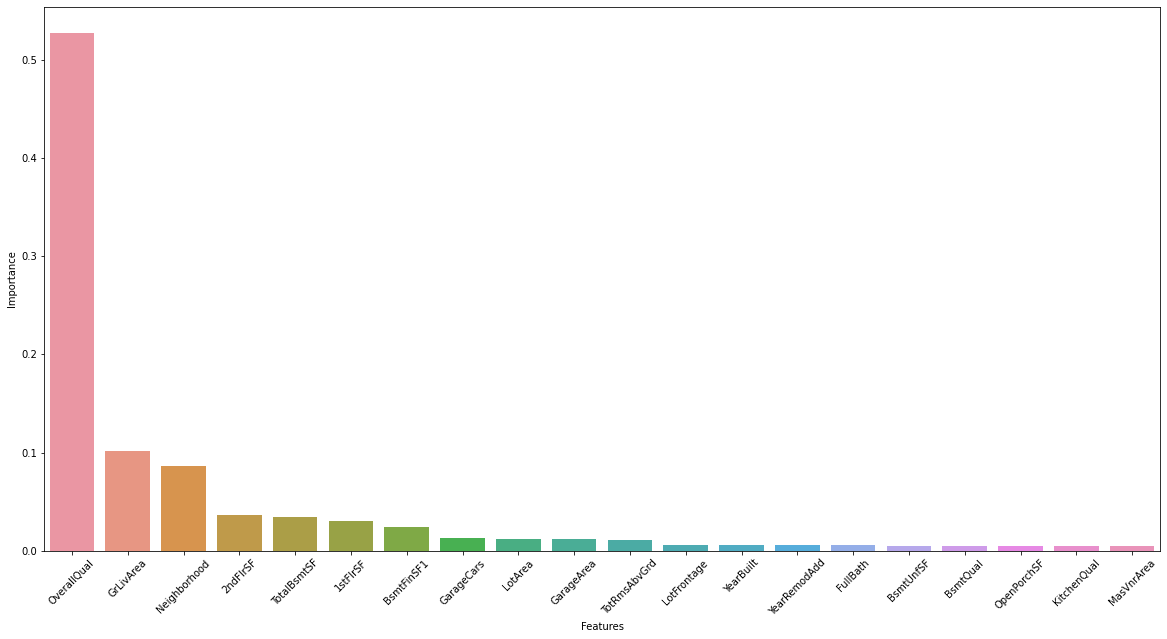

In [34]:
importance_df_reg = pd.DataFrame(np.vstack((df_X_encoded.columns,model.feature_importances_))).T.sort_values(1, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(data=importance_df_reg.iloc[:20,:], x=0, y=1)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')

In [35]:
importance_df_reg.iloc[:20][1].sum()

0.9359415067946505

In [36]:
# Saving the column for Regression analysis
reg_columns = importance_df_reg[0].head(20).values.tolist()

For the regression classification task we will use the 20 features that random forest regression gave more importance.

#### For Classification

In [37]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(df_X_encoded_balanced, y_cat_enc_balanced)

RandomForestClassifier(random_state=1)

Text(0, 0.5, 'Importance')

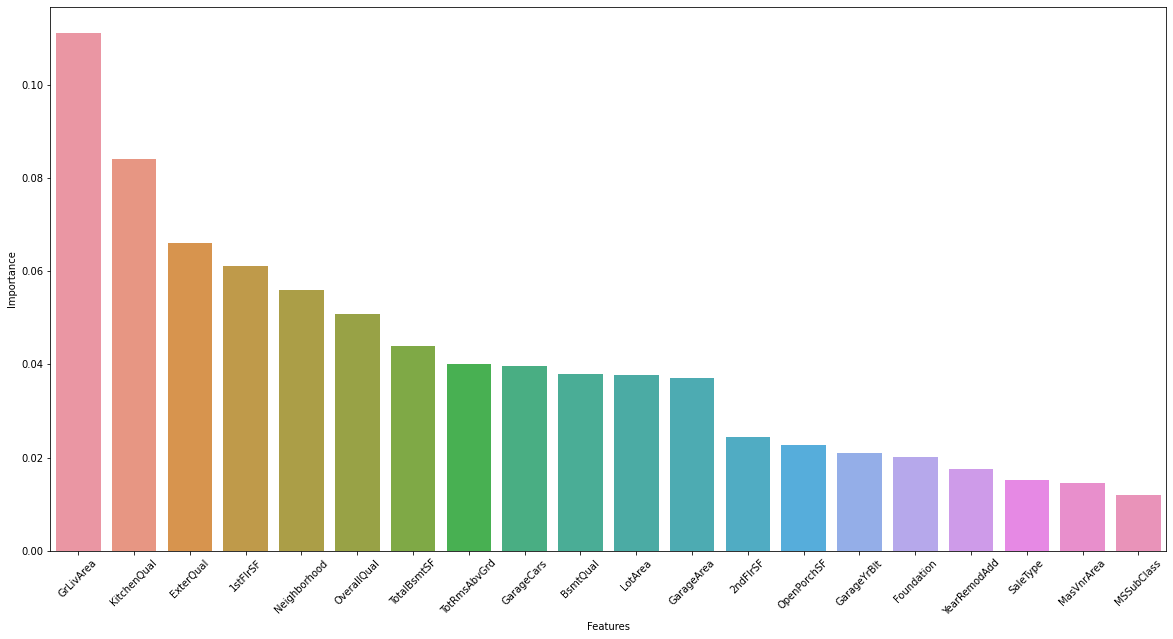

In [38]:
importance_df_clf = pd.DataFrame(np.vstack((df_X_encoded_balanced.columns,model.feature_importances_))).T.sort_values(1, ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(data=importance_df_clf.iloc[:20,:], x=0, y=1)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')

In [39]:
importance_df_clf.iloc[:20][1].sum()

0.8130584194917337

In [40]:
# Saving the column for Classification analysis
clf_columns = importance_df_clf[0].head(20).values.tolist()

For the classification task we will use the 20 features present in the graph above.

## 2. Learning Simple Classifiers

* Choose **`X` classifiers** (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
* Use **grid-search and stratified 10 fold cross-validation** to estimate the best parameters (https://scikit-learn.org/stable/model_selection.html#model-selection). 
* Present mean and standard deviation of accuracy, precision and recall.
* Show confusion matrices.

In [41]:
df_x_clf, y_clf = df_X_encoded_balanced[clf_columns], y_cat_enc_balanced
df_x_clf.shape, y_clf.shape

((3045, 20), (3045,))

Bellow we define a method that receives a list of model and a list of hyperparameters to test. The method will split the data into training and test set, with the test set being 10% of the dataset. Then it will fed the GridSearchCV method that will find the best hyperparameters for the model being tested. The grid search uses cross validation with 10 folds. The method also receives as input a list of pipelines that are used to apply transformations to the data before feeding the machine learning models, such as data scaling. The best models found by the grid search will then be evaluated using the test set. The method saves the results in a pickle file.

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm.notebook import tqdm
import json
import pickle

def train_and_eval(X, y, models, models_kwargs, pipelines, scoring, regression = False, save=None):
    """
    X: the data
    y: the target variable
    models: list of machine learning model classes.
    models_kwargs: list of dictionaries that will be used as keyword arguments for the model.
                    If the kwargs includes a key 'param_grid' with a dictionary of value ranges,
                    the optimum hyperparameters will be searched for using a GridSearch.
    pipelines: list of sklearn pipelines, used to apply transformations on the data before fed the model.
    scoring: the evaluation metric used by grid search to find the best hyper parameters.
    regression: bool indicating if is a regression task.
    save: String. Path to which to save the pickled dataframe.
        This function may be useful as the dataframe includes the objects of the classifiers, which may
        become useful to store to analyze later (beta coefficients, weights, etc.)
    """
    
    results = []
    
    models = list(zip(models, models_kwargs, pipelines))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    for (model, kwargs, pipe) in tqdm(models, desc="Models", leave=False):
        if "param_grid" in kwargs:
            try:
                model = model(random_state=42)
            except:
                model = model()
                
            if pipe == False: 
                grid_search = GridSearchCV(model, kwargs["param_grid"], n_jobs=-1, cv=10,scoring=scoring)
            else:
                pipe.steps.insert(1,['estimator',model])                
                pipe_params = {}
                for key in kwargs["param_grid"]: pipe_params['estimator__{}'.format(key)] = kwargs["param_grid"][key]
                grid_search = GridSearchCV(pipe, pipe_params, n_jobs=-1, cv=10,scoring=scoring)
                
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            params = grid_search.best_params_
            results_best_model = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_]
            best_score = results_best_model.mean_test_score
            best_score_std = results_best_model.std_test_score
            
        else:
            try:
                model = model(**kwargs, random_state=42)
            except:
                model = model(**kwargs)
                
            model.fit(X_train, y_train)
            
            y_pred = model.predict(X_test)
            params = kwargs
            best_score = model.score(X_train, y_train)
            best_score_std = 0.0
        
        if not regression:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='micro')
            rec = recall_score(y_test, y_pred, average='micro')
            
            results.append(pd.DataFrame(data={
                'model': [model],
                'params': [json.dumps(params)],
                'accuracy_train_mean': best_score,
                'accuracy_train_std':best_score_std,
                'accuracy_test': [acc],
                'precision_test': [prec],
                'recall_test' : [rec]
            }))
            
        else: 
            mae = mean_absolute_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared = False)
            results.append(pd.DataFrame(data={
                'model': [model],
                'params': [json.dumps(params)],
                'rmse_train_mean':best_score if not regression else - best_score,
                'rmse_train_std':best_score_std,
                'mae_test': [mae],
                'rmse_test': [rmse],
            }))
                
    df = pd.concat(results, ignore_index=True)
    
    if save is not None:
        with open(save, "wb") as fw:
            pickle.dump(df, fw, pickle.HIGHEST_PROTOCOL)

    return df, X_test, y_test

We decided to test a distance method (KNN), a linear model (logistic regressor) and a probablistic model (naive bayes). For the logistic regressor we define a pipeline that first standardizes the data before fed the model, which is an important preprocessing method for linear models, specially if the dataset contains columns of different types that are measured in different scales. We will use the accuracy metric, in order to find the best parameters in grid search. Then, we will compute the accuracy, precision and recall on the test set.

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import os.path
from os import path

if not path.exists('simple_classifiers.pickle'):
    classifiers = [
        KNeighborsClassifier,
        LogisticRegression,
        GaussianNB
    ]

    classifier_kwargs = [
        {"param_grid": {'n_neighbors':[3,5,7],'weights':['uniform','distance']}},
        {'param_grid': {'C':[0.1,0.5,1,10], 'tol': [1e-2,1e-3,1e-4]},'max_iter': [500]},
        {'param_grid': {}}
    ]

    pipelines = [
        False,
        Pipeline([('scaler', StandardScaler())]),
        False
    ]

    results1, X_test1, y_test1 = train_and_eval(df_x_clf, y_clf, classifiers, classifier_kwargs,pipelines, 'accuracy', save='simple_classifiers.pickle')
    #export test data to pickle
    with open('simple_classifiers_xtest.pickle', "wb") as fw: pickle.dump(X_test1, fw, pickle.HIGHEST_PROTOCOL)
    with open('simple_classifiers_ytest.pickle', "wb") as fw: pickle.dump(y_test1, fw, pickle.HIGHEST_PROTOCOL)
else: 
    results1 = pd.read_pickle('simple_classifiers.pickle')
    X_test1 = pd.read_pickle('simple_classifiers_xtest.pickle')
    y_test1 = pd.read_pickle('simple_classifiers_ytest.pickle')
results1

,model,params,accuracy_train_mean,accuracy_train_std,accuracy_test,precision_test,recall_test
0,"KNeighborsClassifier(n_neighbors=3, weights='d...","{""n_neighbors"": 3, ""weights"": ""distance""}",0.933212,0.011999,0.944262,0.944262,0.944262
1,"(StandardScaler(), LogisticRegression(C=10, ra...","{""estimator__C"": 10, ""estimator__tol"": 0.01}",0.951095,0.008667,0.934426,0.934426,0.934426
2,GaussianNB(),{},0.881387,0.022689,0.862295,0.862295,0.862295


Now lets plot the confusion matrix.

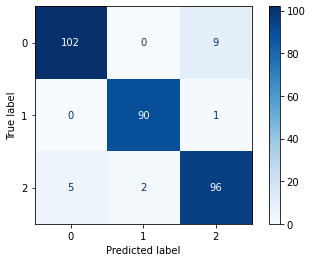

In [44]:
from sklearn.metrics import plot_confusion_matrix

best_clf = results1.iloc[0].model
plot_confusion_matrix(best_clf,X_test1,y_test1, cmap=plt.cm.Blues)

## 3. Learning Simple Regressors

* Choose **`X` regressors** (https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
* Use **grid-search and 10 fold cross-validation** to estimate the best parameters (https://scikit-learn.org/stable/model_selection.html#model-selection). 
* Use the mean absolute error regression loss, or other relevant metrics.

Get the data for the regression task

In [45]:
df_x_reg, y_reg = df_X_encoded[reg_columns], df_y_reg
df_x_reg.shape, y_reg.shape

((1460, 20), (1460, 1))

We will use the same method used in the classification task. We will use grid search, that will search for the best hyper paramaters by using the Root Mean Squared Error (RMSE) evaluation metric. After obtaining the best models, we test them in a the test set, that wasn't used by grid search. In the test set we used both the RMSE and the Mean Absolute Error (MAE) metrics.

In [46]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

if not path.exists('simple_regressors.pickle'):
    regressors = [
        LinearRegression ,
        Lasso,
        Ridge
    ]

    regressors_kwargs = [
        {"param_grid": {}},
        {'param_grid': {'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}},
        {'param_grid': {'alpha':[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]}},
    ]

    pipelines = [
        Pipeline([('scaler', StandardScaler())]),
        Pipeline([('scaler', StandardScaler())]),
        Pipeline([('scaler', StandardScaler())])
    ]

    results2,_,_ = train_and_eval(df_x_reg, y_reg, regressors, regressors_kwargs,pipelines,scoring='neg_root_mean_squared_error', regression = True, save='simple_regressors.pickle')
else: results2 = pd.read_pickle('simple_regressors.pickle')
results2

,model,params,rmse_train_mean,rmse_train_std,mae_test,rmse_test
0,"(StandardScaler(), LinearRegression())",{},34550.093512,10336.454052,21513.494235,38123.110178
1,"(StandardScaler(), Lasso(alpha=75, random_stat...","{""estimator__alpha"": 75}",34477.399811,10233.285328,21601.322422,38267.958821
2,"(StandardScaler(), Ridge(alpha=75, random_stat...","{""estimator__alpha"": 75}",34282.090577,10079.956063,21509.005300,38434.809156


## 4. Ensemble Learning

### Voting Classifier/Regressor

* Use a voting classifier (http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)/regressor(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) to combine the best results of the `X` classifiers/regressors from previous sections. 

In [103]:
df_x_clf, y_clf = df_X_encoded_balanced[clf_columns], y_cat_enc_balanced
df_x_clf.shape, y_clf.shape

((3045, 20), (3045,))

In [104]:
from sklearn.ensemble import VotingClassifier

if not path.exists('vc_classifiers.pickle'):
    classifier = [VotingClassifier]

    cl1 = KNeighborsClassifier(n_neighbors=3, weights='distance')
    cl2 = LogisticRegression(C=10, tol=0.01, max_iter=500)
    cl3 = GaussianNB()


    classifiers_kwargs = [
            {'estimators': [('kn', cl1), ('lr', cl2), ('gnb', cl3)], 'voting': 'hard'}]

    pipelines = [
        Pipeline([('scaler', StandardScaler())])
    ]

    results_vc,_,_ = train_and_eval(df_x_clf, y_clf, classifier, classifiers_kwargs,pipelines,scoring= 'accuracy', regression = False, save='vc_classifiers.pickle')
else: results_vc = pd.read_pickle('vc_classifiers.pickle')
results_vc

,model,params,accuracy_train_mean,accuracy_train_std,accuracy_test,precision_test,recall_test
0,"VotingClassifier(estimators=[('kn',\n ...","{'estimators': [('kn', KNeighborsClassifier(n_...",0.972993,0.0,0.937705,0.937705,0.937705


### XGBoost & Random Forests

* Use [Random Forests](http://scikit-learn.org/stable/modules/ensemble.html#random-forests).
* Use [XGBoost](https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn).

In [101]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

if not path.exists('ensemble_classifiers.pickle'):
    classifiers = [
        XGBClassifier,
        RandomForestClassifier
    ]
    cl1 = KNeighborsClassifier(n_neighbors=3, weights='distance')
    cl2 = LogisticRegression(C=10, tol=0.01, max_iter=500)
    cl3 = GaussianNB()
    
    classifiers_kwargs = [
        {'param_grid': {'objective': ["multi:softprob"], 'n_estimators': [5,10,15,20,50,100]}},
        {'param_grid': {'n_estimators':[10,50,100,200,300,400,500], 'criterion': ['gini', 'entropy']}},
    ]

    pipelines = [
        False,
        False
    ]

    results3,_,_ = train_and_eval(df_x_clf, y_clf, classifiers, classifiers_kwargs,pipelines,scoring= 'accuracy', regression = False, save='ensemble_classifiers.pickle')
else: results3 = pd.read_pickle('ensemble_classifiers.pickle')
results3

,model,params,accuracy_train_mean,accuracy_train_std,accuracy_test,precision_test,recall_test
0,"XGBClassifier(base_score=0.5, booster='gbtree'...","{""n_estimators"": 50, ""objective"": ""multi:softp...",0.971168,0.009440,0.947541,0.947541,0.947541
1,"(DecisionTreeClassifier(criterion='entropy', m...","{""criterion"": ""entropy"", ""n_estimators"": 100}",0.969343,0.007862,0.944262,0.944262,0.944262


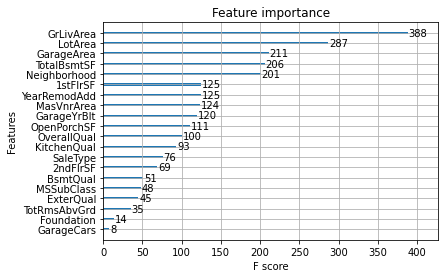

In [102]:
import xgboost as xgb
import graphviz

XGB_model = results3.iloc[0].model
xgb.plot_importance(XGB_model)

**References**

[1] https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

